# Finm35000 Data project 1

Team Members:
- Antonio Pineda Acosta
- Kaleem Shah Bukhari
- Raafay Uqailya
- Yasmine Ouattara

## Section 2: Measuring the tone of FOMC statements (90 points)

#### You will follow the method in Tadle (2022). The paper is linked on Canvas.

In [46]:
import requests
import string
from fredapi import Fred
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import re
import datetime as dt
import statsmodels.api as sm


### 1. (10 points) Scrape the text of the FOMC statements from January 2000 to the present. 

Use https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm for 2019-2024 and https://www.federalreserve.gov/monetarypolicy/fomc historical year.htm for 2000-2018.

Here are some hints provided by Joanna for scraping if scraping is new to you.

- Use the BeautifulSoup package to extract the html from the website. Load this package by running the code: from bs4 import BeautifulSoup.

- Use the command soup.findall(‘a’,href=True) to get a list of all the URL links on the web page.

- Inspect the URLs to figure out what the format of the links to statement files look like and narrow your list of links to only include these.

- Iterate through the links to the statements and again use the BeautifulSoup package to extract the text.

- Inspect the text to remove extraneous parts from the start and end. Make sure to remove HTML tags.

- You will need the date of the statement to merge the text to the returns. It can be found in the URL. For example, https: //www.federalreserve.gov/newsevents/pressreleases/monetary20220126a.htm  was released on Jan. 26, 2022, which is at the end of the URL.

Report the following after you extract the text: 1) Number of statements you obtain and the list of the dates of their release. The statements are released shortly after each FOMC meeting. 2) A summary statistic of the number of words in statements including mean, standard deviation, minimum, first quartile, median, third quartile, maximum.

### 2019-2024

In [23]:
# Function to extract the statement links from the 2019-2024 URL
def extract_statement_links_2019_2024(url):
    """
    Input:
        url (str): The URL of the webpage to scrape.
    Output:
        list of str: A list of URLs containing FOMC press release statements.
    """

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract all URLs that contain 'pressrelease' (which likely include FOMC statements)
    fomc_links = soup.find_all('a', href=True)
    
    # Filter links for FOMC statements based on a common pattern in the URL
    statement_links = [link['href'] for link in fomc_links if 'pressrelease' in link['href']]
    return statement_links

# Function to clean and extract the relevant FOMC statement text
def extract_statement_text_2019_2024(links):
    """
    Input:
        links (list): A list of FOMC statements links
    Ouput:
        statements (list), dates (list): A list of relevant statements & A list of release dates
    """
    base_url = "https://www.federalreserve.gov"
    statements = []
    dates = []
    
    for link in links:
        full_url = base_url + link  # Construct the full URL
        statement_response = requests.get(full_url)
        
        # Fix encoding issues by decoding the content as UTF-8
        statement_soup = BeautifulSoup(statement_response.content.decode('utf-8'), 'html.parser')
        
        # Extract the entire text of the page
        full_text = statement_soup.get_text().strip()

        # Find the start of the relevant FOMC statement
        start_marker = "Please enable JavaScript if it is disabled in your browser or access the information through the links provided below."
        end_marker = "About the FedNews & EventsMonetary PolicySupervision & RegulationFinancial StabilityPayment SystemsEconomic ResearchDataConsumers & CommunitiesConnect with the Board"
        
        start_index = full_text.find(start_marker)
        end_index = full_text.find(end_marker)
        
        if start_index != -1 and end_index != -1:
            # Extract the relevant portion of the text between the start and end markers
            relevant_text = full_text[start_index + len(start_marker):end_index]
            
            # Extract date from the URL using regex (as an example of 20220126a.htm)
            match = re.search(r'(\d{8})a\.htm', link)
            
            if relevant_text and match:  # Ensure both statement text and date are found
                date = match.group(1)  # Extracts the date part (e.g., 20220126)
                dates.append(date)
                statements.append(relevant_text.strip())
    
    return statements, dates

# URL for scraping 2019-2024 statements
url_2019_2024 = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"

# Extract statement links for the 2019-2024 period
statement_links_2019_2024 = extract_statement_links_2019_2024(url_2019_2024)

# Extract statement texts and dates for the 2019-2024 period
statements_2019_2024, dates_2019_2024 = extract_statement_text_2019_2024(statement_links_2019_2024)

# Create a dataframe for the 2019-2024 period
data_2019_2024 = {'Date': dates_2019_2024, 'Statement Text': statements_2019_2024}
df_2019_2024 = pd.DataFrame(data_2019_2024)

#from Date make this format 2000-01-19
df_2019_2024['Date'] = pd.to_datetime(df_2019_2024['Date'], format='%Y%m%d')
df_2019_2024['Date'] = df_2019_2024['Date'].dt.strftime('%Y-%m-%d')

# Save the DataFrame to an Excel file
output_file_path_2019_2024 = 'Data/FOMC_statements_2019_2024.xlsx'
df_2019_2024.to_excel(output_file_path_2019_2024, index = False)

# Display the DataFrame for verification
df_2019_2024.head()

,Date,Statement Text
0,2024-01-31,"January 31, 2024\nFederal Reserve issues FOMC ..."
1,2024-03-20,"March 20, 2024\nFederal Reserve issues FOMC st..."
2,2024-05-01,"May 01, 2024\nFederal Reserve issues FOMC stat..."
3,2024-06-12,"June 12, 2024\nFederal Reserve issues FOMC sta..."
4,2024-07-31,"July 31, 2024\nFederal Reserve issues FOMC sta..."


### 2000-2018

In [24]:
# List of specific dates to remove
dates_to_remove = [
    "1996-10-01", "1996-12-01", "1997-01-01", "1997-03-01", "1997-05-01", "1997-06-01",
    "1997-08-01", "1997-09-01", "1997-10-01", "1997-12-01", "1998-01-01", "1998-03-01",
    "1998-05-01", "1998-06-01", "1998-08-01", "1998-09-01", "1998-11-01", "1998-12-01",
    "1999-01-01", "1999-03-01", "1999-05-01", "1999-06-01", "1999-08-01", "1999-09-01",
    "1999-11-01", "1999-12-01", "2000-01-01", "2000-03-01", "2000-05-01", "2000-06-01",
    "2000-08-01", "2000-09-01", "2000-11-01", "2000-12-01", "2001-01-01", "2001-03-01",
    "2001-05-01", "2001-06-01", "2001-08-01", "2001-09-01", "2001-10-01", "2001-11-01",
    "2002-01-01", "2002-03-01", "2002-04-01", "2002-06-01", "2002-07-01", "2002-10-01",
    "2002-11-01", "2003-01-01", "2003-03-01", "2003-04-01", "2003-06-01", "2003-07-01",
    "2003-10-01", "2003-11-01", "2004-01-01", "2004-03-01", "2004-04-01", "2004-06-01",
    "2004-07-01", "2004-09-01", "2004-10-01", "2004-12-01", "2005-01-01", "2005-03-01",
    "2005-04-01", "2005-06-01", "2005-07-01", "2005-09-01", "2005-10-01", "2005-11-01",
    "2006-01-01", "2006-03-01", "2006-04-01", "2006-06-01", "2006-07-01", "2006-09-01",
    "2006-10-01", "2006-11-01", "2007-01-01", "2007-03-01", "2007-04-01", "2007-06-01",
    "2007-07-01", "2007-09-01", "2007-10-01", "2007-11-01", "2008-01-01", "2008-03-01",
    "2008-04-01", "2008-06-01", "2008-07-01", "2008-09-01", "2008-10-01", "2008-12-01",
    "2009-01-01", "2009-03-01", "2009-04-01", "2009-06-01", "2009-07-01", "2009-09-01",
    "2009-10-01", "2009-12-01", "2010-01-01", "2010-03-01", "2010-04-01", "2010-06-01",
    "2010-07-01", "2010-09-01", "2010-10-01", "2010-12-01"
]

In [25]:
# Function to extract the statement links for a given year based on its period
def extract_yearly_links(year):
    if 2000 <= year <= 2010:
        url = f"https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm"
        link_pattern = r'/fomc/beigebook/\d{4}/\d{8}/default.htm'
    elif 2011 <= year <= 2016:
        url = f"https://www.federalreserve.gov/monetarypolicy/beigebook/beigebook{year}.htm"
        link_pattern = r'/monetarypolicy/beigebook/beigebook\d{6}.htm'
    else:  # 2017-2018
        url = f"https://www.federalreserve.gov/monetarypolicy/beigebook{year}.htm"
        link_pattern = r'/monetarypolicy/beigebook\d{6}.htm'

    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    links = soup.find_all('a', href=True)
    
    # Filter only the relevant Beige Book links based on the year pattern
    relevant_links = [link['href'] for link in links if re.search(link_pattern, link['href'])]
    
    return relevant_links

# Function to extract the statement text from an HTML link
def extract_statement_text(link):
    base_url = "https://www.federalreserve.gov"
    full_url = base_url + link if link.startswith('/') else base_url + '/' + link
    response = requests.get(full_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.get_text().strip()
    
    # Phrase that marks the start of relevant content
    start_marker = "the views of Federal Reserve officials."
    # Find the starting point in the text
    start_index = text.find(start_marker)
    
    if start_index != -1:
        # Extract the relevant part after the start_marker
        relevant_text = text[start_index + len(start_marker):].strip()
        return relevant_text
    else:
        # If the start marker is not found, return None
        return None

# Function to extract FOMC statements for a given year range
def extract_fomc_statements(start_year, end_year):
    all_statements = []
    all_dates = []

    for year in range(start_year, end_year + 1):
        print(f"Processing year: {year}")
        links = extract_yearly_links(year)

        for link in links:
            if year <= 2010:
                match = re.search(r'/fomc/beigebook/(\d{4})/(\d{8})/default.htm', link)
            else:
                match = re.search(r'beigebook(\d{4})(\d{2})', link)

            if match:
                if year <= 2010:
                    date = match.group(2)
                else:
                    year_str = match.group(1)
                    month = match.group(2)
                    date = f"{year_str}{month}01"

                if date not in all_dates:  # Prevent duplicate entries
                    statement_text = extract_statement_text(link)
                    if statement_text:  # Only append if the relevant text is found
                        all_dates.append(date)
                        all_statements.append(statement_text)

    # Convert the date strings to datetime objects for filtering and sorting
    all_dates = pd.to_datetime(all_dates, format='%Y%m%d')
    
    # Create a DataFrame with the filtered and ordered data
    df = pd.DataFrame({'Date': all_dates, 'Statement Text': all_statements})

    # Filter out the specific dates we want to remove
    df = df[~df['Date'].isin(pd.to_datetime(dates_to_remove))]

    df = df.sort_values(by='Date')  # Sort by date

    return df

# Extract statements for each period and combine them
df_2000_2010 = extract_fomc_statements(2000, 2010)
df_2011_2016 = extract_fomc_statements(2011, 2016)
df_2017_2018 = extract_fomc_statements(2017, 2018)

# Merge all the DataFrames into one
df_2000_2018 = pd.concat([df_2000_2010, df_2011_2016, df_2017_2018])

# Save the final DataFrame to a single Excel file
output_file_path = 'Data/FOMC_statements_2000_2018_filtered_cleaned.xlsx'
df_2000_2018.to_excel(output_file_path, index=False)

# Display the merged DataFrame for verification
df_2000_2018.head()

Processing year: 2000
Processing year: 2001
Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018


,Date,Statement Text
0,2000-01-19,Reports from most Federal Reserve Districts in...
1,2000-03-08,Reports from the twelve Federal Reserve Distri...
2,2000-05-03,Reports from the twelve Federal Reserve Distri...
3,2000-06-14,Reports from the Federal Reserve Districts ind...
4,2000-08-09,The information collected for these reports su...


### Statistics

In [26]:
# Merge all the DataFrames into one
df_all_years = pd.concat([df_2000_2018, df_2019_2024])

# Ensure 'Date' column is in datetime format
df_all_years['Date'] = pd.to_datetime(df_all_years['Date']).dt.strftime('%Y-%m-%d')

# Order by date
df_all_years = df_all_years.sort_values(by='Date')

#df_all_years.head()
df_all_years.tail()

,Date,Statement Text
1,2024-03-20,"March 20, 2024\nFederal Reserve issues FOMC st..."
2,2024-05-01,"May 01, 2024\nFederal Reserve issues FOMC stat..."
3,2024-06-12,"June 12, 2024\nFederal Reserve issues FOMC sta..."
4,2024-07-31,"July 31, 2024\nFederal Reserve issues FOMC sta..."
5,2024-09-18,"September 18, 2024\nFederal Reserve issues FOM..."


In [27]:
# Add the word count for each statement
df_all_years['Word Count'] = df_all_years['Statement Text'].apply(lambda x: len(x.split()))

# Calculate summary statistics for the word count
summary_stats = df_all_years['Word Count'].describe()

# Display the summary statistics
print(summary_stats)

count      170.000000
mean      7124.458824
std       7892.273684
min        163.000000
25%        526.500000
50%       2032.000000
75%      17232.500000
max      20050.000000
Name: Word Count, dtype: float64


In [28]:
# Save the final DataFrame and summary statistics to a single Excel file
output_file_path = 'Output_Files/FOMC_statements_with_summary_statistics.xlsx'

# Save both the data and the summary statistics in the same Excel file using ExcelWriter
with pd.ExcelWriter(output_file_path) as writer:
    df_all_years.to_excel(writer, sheet_name='FOMC Statements', index=False)
    summary_stats.to_frame(name='Summary Statistics').to_excel(writer, sheet_name='Summary Statistics')

### 2. (30 points) Follow Tadle (2022) section 3.1 (pages 4-8) to measure the tone of each FOMC statement. Here is a brief description of his method and some programming suggestions.

- Split the statement into sentences using sent tokenize from the nltk package in Python.

- Remove punctuation and capitalization.

- Remove all sentences that do not contain any keywords defined as those from the hawkish or dovish lists in the Excel file provided (Tadle 2022 keywords).

- For each remaining sentence, count the number of positive and negative keywords, adjusting for negation terms. For example, “When a positive term is in the proximity (occurred after three words or less) of a negation term, then its effect is counted as negative.” See Table 3 in Tadle (2022) for a list of examples.

- Use equation (1) on page 7 of Tadle (2022) to assign sentiment scores to each sentence. Footnote 13 on page 7 tells you how to handle sentences that contain both hawkish and dovish keywords.

- Aggregate across sentences to get the document-level score for each FOMC statement by following equation (2) on page 7 of Tadle (2022).

Plot the computed sentiment of each FOMC statement since January 2000. Please plot the dots only; donot connect dots with lines.

In [29]:
# Loading the keywords into a Pandas DataFrame
keywords_df = pd.read_excel('Data/Tadle_2022_keywords.xlsx')

# Display the first 5 rows of the dataframe
keywords_df.head()

,hawkish,dovish,positive,negative,negation
0,business,accomodation,abating,adverse,fail
1,economy,downturn,augmented,contracting,less
2,equity,unemployment,booming,damping,never
3,housing,devastation,elevating,declining,no
4,inflationary,recession,extended,depressed,not


In [30]:
# Converting DataFrame into a Dictionary
# Keys: Word Categories ('hawkish', 'dovish', 'positive', 'negative', 'negation')
# Values: List of words associated with each word category

list_of_categories = ['hawkish', 'dovish', 'positive', 'negative', 'negation']

# Empty Dictionary to store word categories and associated values
keywords_dict = {}

# Looping over the dataframe to populate the dictionary
for cat_ in list_of_categories:
    cat_words_list = keywords_df[cat_].dropna().tolist()
    if cat_ not in keywords_dict:
        keywords_dict[cat_] = cat_words_list

In [31]:
# Function designed to do the following
# 1. Split the statement into sentences
# 2. Perform data cleaning. i.e. Remove punctuations and Capitalization
# 3. Extract relevant sentences, where relevant is defined as sentence that contains
# atleast 1 Hawkish or Dovish keyword
# 4. Return a dictionary with original statement divided into sentences against each date and Return a dictionary
# with Relevant sentences against each date

def clean_process_sentences(statements_df, hawkish_word_list, dovish_word_list):

    """
    Input:
        statments_df (DataFrame): A DataFrame of FOMC statements
        hawkish_word_list (list): List of hawkish keywords.
        dovish_word_list (list): List of dovish keywords.

    Output:
        tokenized_sentence_dict (dictionary): A dictionary where key-value pairs are
                                              key: statement date
                                              values: list of tokenized sentences for each key
        hawkish_dovish_sentence_dict (dictionary): A dictionary where key-value pairs are
                                                   key: statement date
                                                   values: list of Relevant sentences for each key  
    """

    statements_df = statements_df.copy()
    #statements_df['Date'] = statements_df['Date'].strftime('%Y-%m-%d')
    
    keyword_list_combined = hawkish_word_list.copy() + dovish_word_list.copy()
    
    tokenized_sentence_dict = {}
    clean_sentences_dict = {}
    hawkish_dovish_sentence_dict = {}
    irrelevant_sentences_dict = {}

    for index, stmnt in statements_df.iterrows():
        
        tokenized_sentences = ""
        statement = str(stmnt['Statement Text'])
        tokenized_sentences = sent_tokenize(statement)
        
        if stmnt['Date'] not in tokenized_sentence_dict:
            tokenized_sentence_dict[stmnt['Date']] = tokenized_sentences
        
        clean_sentence = ""
        hawkish_dovish_sentence = ""
        irrelevant_sentence = ""
        
        clean_sentences_list = []
        hawkish_dovish_sentence_list = []
        irrelevant_sentences_list = []
        
        for sntnc in tokenized_sentences:    
        
            tokenized_words = ""
            tokenized_words = word_tokenize(sntnc)
            clean_tokenized_words = [word_.lower() for word_ in tokenized_words if word_ not in string.punctuation]
            clean_sentence = ' '.join(clean_tokenized_words)
            clean_sentences_list.append(clean_sentence)
            
            if any(word_ in keyword_list_combined for word_ in clean_tokenized_words):
                hawkish_dovish_sentence = clean_sentence
                hawkish_dovish_sentence_list.append(hawkish_dovish_sentence)
            else:
                irrelevant_sentence = clean_sentence
                irrelevant_sentences_list.append(irrelevant_sentence)
            
        if stmnt['Date'] not in clean_sentences_dict:
            clean_sentences_dict[stmnt['Date']] = clean_sentences_list
        
        if stmnt['Date'] not in hawkish_dovish_sentence_dict:
            hawkish_dovish_sentence_dict[stmnt['Date']] = hawkish_dovish_sentence_list
        
        if stmnt['Date'] not in irrelevant_sentences_dict:
            irrelevant_sentences_dict[stmnt['Date']] = irrelevant_sentences_list
        
    return tokenized_sentence_dict, hawkish_dovish_sentence_dict, irrelevant_sentences_dict

In [32]:
def calculate_sentence_score(list_of_words, hawkish_word_list, dovish_word_list, 
                             positive_word_list, negative_word_list,negation_word_list):
    
    hawkish_word_cnt = 0
    dovish_word_cnt = 0
    positive_word_cnt = 0
    negative_word_cnt = 0
    negation_proximity_threshold = 3

    for idx, word_ in enumerate(list_of_words):
        if word_ in hawkish_word_list:
            #print(word_)
            hawkish_word_cnt += 1
        
        if word_ in dovish_word_list:
            dovish_word_cnt += 1
        
        # Positive Word Count logic
        # First check for negation criterion, if it is True then increment Negative Word Count by 1
        if word_ in positive_word_list:
            left_limit = max(0, idx - negation_proximity_threshold)
            if any(negation_word in list_of_words[left_limit : idx] for negation_word in negation_word_list):
                negative_word_cnt += 1
        # Otherwise, increase Positive Word Count by 1
            else:
                positive_word_cnt += 1
        
        # Negative Word Count logic
        # First check for negation criterion, if it is True then increment Positive Word Count by 1
        elif word_ in negative_word_list:
            left_limit = max(0, idx - 1)
            if any(negation_word in list_of_words[left_limit : idx] for negation_word in negation_word_list):
                positive_word_cnt += 1
        # Otherwise, increase Negative Word Count by 1
            else:
                negative_word_cnt += 1
    #print(list_of_words)
    #print(f"Hawkish: {hawkish_word_cnt}, Dovish: {dovish_word_cnt}, Positive: {positive_word_cnt}, Negative: {negative_word_cnt}")
    
    if hawkish_word_cnt > 0:
        #print('Enter Hawkish Loop')
        if positive_word_cnt == negative_word_cnt:
            #print('pos = negative')
            return 1  # Only hawkish words
        elif positive_word_cnt > negative_word_cnt:
            #print('pos > neg')
            return 1  # Positive hawkish sentiment
        elif negative_word_cnt > positive_word_cnt:
            #print('neg > pos')
            return -1  # Negative hawkish sentiment

    elif dovish_word_cnt > 0:
        #print('Enter Dovish Loop')
        if positive_word_cnt == negative_word_cnt:
            #print('pos = negative')
            return -1  # Only dovish words
        elif positive_word_cnt > negative_word_cnt:
            #print('pos > neg')
            return -1  # Negative dovish sentiment
        elif negative_word_cnt > positive_word_cnt:
            #print('neg > pos')
            return 1  # Positive dovish sentiment
    else:
        #print('Neutral')
        return 0

In [33]:
# Function assigns score to each sentence
# Utilizes the function calculate_sentence_score, which returns 1, -1, 0 based on the logic

def assign_sentence_score(relevant_sentence_dict,hawkish_word_list, dovish_word_list,
                          positive_word_list, negative_word_list, negation_word_list):
    
    date_sentence_score_dict = {}
    
    for date, list_of_sentences in relevant_sentence_dict.items():
        
        sentence_score_dict = {}

        for sntnc in list_of_sentences:
            
            sentence_score = 0
            tokenized_words_list = word_tokenize(sntnc)
            sentence_score = calculate_sentence_score(tokenized_words_list, hawkish_word_list, dovish_word_list, 
                                                      positive_word_list, negative_word_list,negation_word_list)
            
            sentence_score_dict[sntnc] = sentence_score
        
        date_sentence_score_dict[date] = sentence_score_dict
    
    return date_sentence_score_dict

In [34]:
def assign_document_score(relevant_sentence_dict,hawkish_word_list, dovish_word_list,
                          positive_word_list, negative_word_list, negation_word_list):
    
    date_sentence_score_dict = assign_sentence_score(relevant_sentence_dict, keywords_hawkish, keywords_dovish, 
                                                     keywords_positive, keywords_negative, keywords_negation)
    
    date_document_score_index_dict = {}

    for date, sentence_score_dict in date_sentence_score_dict.items():
        
        total_document_score = 0
        num_rlvnt_sntncs = 0
        
        num_rlvnt_sntncs = len(sentence_score_dict.keys())
        total_document_score = sum(sentence_score_dict.values())
        #print(f"nd: {num_rlvnt_sntncs}, Total Document Score:{total_document_score}")
        
        index_ = 100 * (1/num_rlvnt_sntncs) * total_document_score
        date_document_score_index_dict[date] = index_
    
    return date_document_score_index_dict

In [35]:
keywords_hawkish = keywords_dict['hawkish']
keywords_dovish = keywords_dict['dovish']
keywords_positive = keywords_dict['positive']
keywords_negative = keywords_dict['negative']
keywords_negation = keywords_dict['negation']

In [36]:
sntnc_dict, hwksh_dvsh_sntnc_dict, irlvnt_sntc_dict = clean_process_sentences(df_all_years, keywords_hawkish, keywords_dovish)

In [38]:
date_indx_score_dict = assign_document_score(hwksh_dvsh_sntnc_dict,keywords_hawkish, keywords_dovish, keywords_positive, keywords_negative, keywords_negation)

In [39]:
date_indx_score_df = pd.DataFrame.from_dict(date_indx_score_dict, orient = 'index')
date_indx_score_df.reset_index(inplace = True)
date_indx_score_df.rename(columns = {'index':'Date', 0:'Index Score'}, inplace = True)
date_indx_score_df.head()

,Date,Index Score
0,2000-01-19,75.000000
1,2000-03-08,86.046512
2,2000-05-03,89.189189
3,2000-06-14,56.000000
4,2000-08-09,44.680851


In [40]:
# Save the DataFrame for Index (Sentiment) Scores against each Press Release Date into an excel sheet
output_file_path = 'Output_Files/FOMC_statement_date_sentiment_score.xlsx'

with pd.ExcelWriter(output_file_path) as writer:
    date_indx_score_df.to_excel(writer, sheet_name = 'Sentiment Score', index=False)

In [142]:
date_indx_score_df = pd.read_excel('Output_Files/FOMC_statement_date_sentiment_score.xlsx')

In [143]:
date_indx_score_df['Date'] = pd.to_datetime(date_indx_score_df['Date'])
date_indx_score_df.set_index('Date', inplace=True)
date_indx_score_df.head()

,Index Score
Date,
2000-01-19,75.000000
2000-03-08,86.046512
2000-05-03,89.189189
2000-06-14,56.000000
2000-08-09,44.680851


/opt/anaconda3/envs/tsaf/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


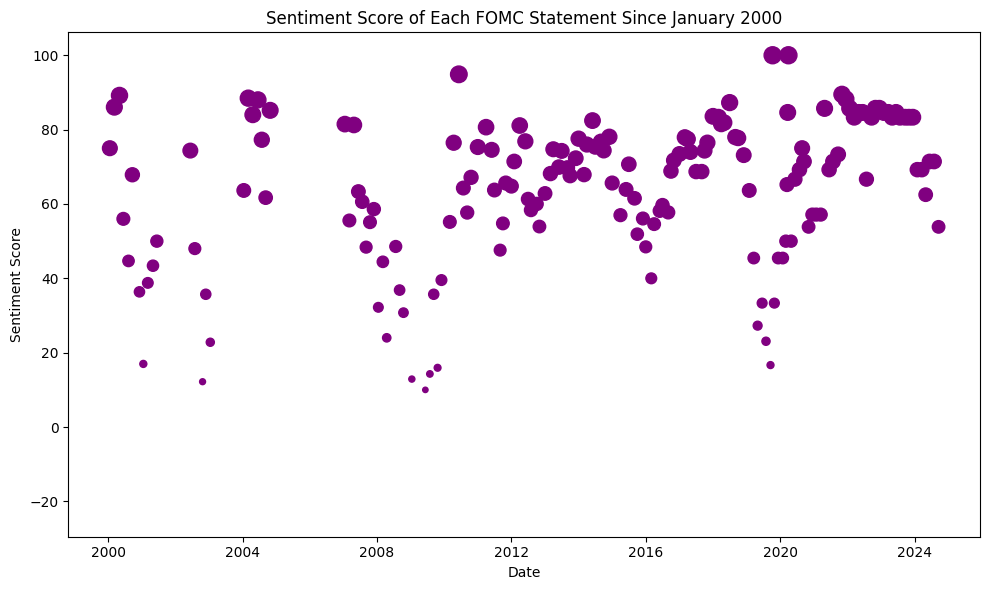

In [144]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with dot size based on "Index Score"
ax.scatter(date_indx_score_df.index, date_indx_score_df["Index Score"],
           s = date_indx_score_df["Index Score"] * 1.5, color = 'purple')

# Set title and labels
ax.set_title("Sentiment Score of Each FOMC Statement Since January 2000")
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment Score")

# Adjust layout and display
plt.tight_layout()
plt.show()

### 3. (10 points) From FRED (Federal Reserve Economic Data, https://fred.stlouisfed.org/) find the following data series: 
- 1) Federal Funds Target Rate (DFEDTAR) and 
- 2) Federal Funds Target Range-Upper (DFEDTARU). 

You can search the “ticker symbol” (Capital letters in parenthesis) for each series given. FOMC used to announce a targeted value for the Federal Funds Rate (FFR) before Dec. 15th, 2008. 

Since that date, FOMC has announced a range. We will use the upper limit. Compute the change of the target on each of the FOMC statement release date. Plot these changes together with sentiment score you computed in the previous section. What do you find?

In [145]:
fred_api_key = '6014571ef89b16f87265e5d0b7644011' 
fred = Fred(api_key = fred_api_key)

In [173]:
import xml.etree.ElementTree as ET

# Replace with your API key
api_key = fred_api_key

# Function to fetch FRED data and parse XML
def fetch_fred_data(series_id):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=xml"
    response = requests.get(url)
    response_text = response.text
    
    root = ET.fromstring(response_text)
    data = {}
    for observation in root.findall(".//observation"):
        date = observation.get('date')
        value = observation.get('value')
        try:
            data[date] = float(value)
        except ValueError:
            data[date] = None 
    
    return pd.Series(data)

# Fetch data for each series
dfedtar_data = fetch_fred_data('DFEDTAR')
dfedtaru_data = fetch_fred_data('DFEDTARU')

# Combine into a DataFrame
fed_data = pd.DataFrame({'DFEDTAR': dfedtar_data, 'DFEDTARU': dfedtaru_data})

# Convert the index to datetime format
fed_data.index = pd.to_datetime(fed_data.index)

# Define cutoff date and create Target_Rate column
cutoff_date = pd.Timestamp('2008-12-15')
fed_data['Target_Rate'] = fed_data.apply(
    lambda row: row['DFEDTAR'] if row.name <= cutoff_date else row['DFEDTARU'], axis=1
)

# Drop unnecessary columns and display the result
fed_data = fed_data.drop(columns=['DFEDTAR', 'DFEDTARU']).reset_index().rename(columns={'index':'Date'})
fed_data.head()


,Date,Target_Rate
0,1982-09-27,10.25
1,1982-09-28,10.25
2,1982-09-29,10.25
3,1982-09-30,10.25
4,1982-10-01,10.00


In [147]:
# dfedtar_data = fred.get_series('DFEDTAR')
# dfedtaru_data = fred.get_series('DFEDTARU')

# fed_data = pd.DataFrame({'DFEDTAR': dfedtar_data, 'DFEDTARU': dfedtaru_data})

# cutoff_date = pd.Timestamp('2008-12-15')

# # Assign 'Target_Rate' based on the cutoff date condition
# fed_data['Target_Rate'] = fed_data['DFEDTAR']
# fed_data.loc[fed_data.index > cutoff_date, 'Target_Rate'] = fed_data['DFEDTARU']

# fed_data = fed_data.drop(columns=['DFEDTAR', 'DFEDTARU'])

# fed_data.head()

In [148]:
#fed_data.index = pd.to_datetime(fed_data.index)
date_indx_score_df.reset_index(inplace = True)
date_indx_score_df['Date'] = pd.to_datetime(date_indx_score_df['Date'])

doc_index_score_ffr_target_df = pd.merge(date_indx_score_df, fed_data, left_on = 'Date', right_on = 'Date', how = 'inner')
doc_index_score_ffr_target_df['MOPL'] = doc_index_score_ffr_target_df['Target_Rate'].diff()

doc_index_score_ffr_target_df.head()

,Date,Index Score,Target_Rate,MOPL
0,2000-01-19,75.000000,5.50,NaN
1,2000-03-08,86.046512,5.75,0.25
2,2000-05-03,89.189189,6.00,0.25
3,2000-06-14,56.000000,6.50,0.50
4,2000-08-09,44.680851,6.50,0.00


### Plotting Data

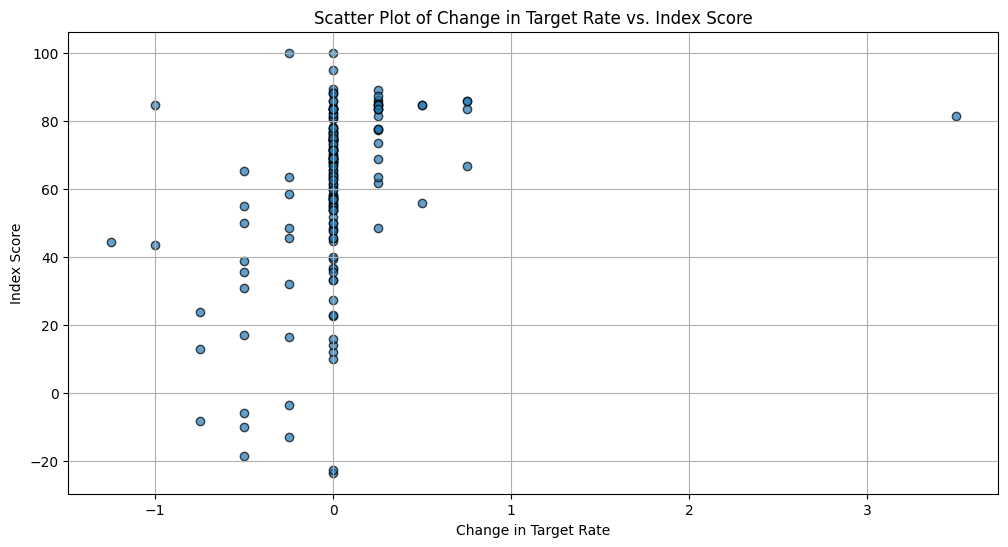

In [150]:
plt.figure(figsize=(12, 6))
plt.scatter(doc_index_score_ffr_target_df['MOPL'], doc_index_score_ffr_target_df['Index Score'], alpha=0.7, edgecolor='k')

plt.xlabel('Change in Target Rate')
plt.ylabel('Index Score')
plt.title('Scatter Plot of Change in Target Rate vs. Index Score')

plt.grid()
plt.show()

## Section 3: Measuring the impact on the bond market (40 points)

We are going to treat the changes in the FFR targets and the calculated sentiments of FOMC statements a la Tadle (2022) as if they are surprises. See Aruoba and Drechsel (2022) to see why this is not a realistic assumption.

### 1. (5 points) From FRED find the following data series: 1) EFFR, 2) DGS1MO, and 3) DGS10. Make sure that you read their description. Compute the changes of values in these series on the date of FOMC meeting from the previous day. Provide summary statistics including, number of observations, mean, median, and standard deviation.


In [204]:
def fetch_multiple_fred_data(series_ids):
    """
    Fetch multiple time series from FRED in one go.

    Parameters:
    - series_ids: list of str, each representing a FRED series ID.

    Returns:
    - DataFrame with each series as a column, indexed by date.
    """
    data = {}

    for series_id in series_ids:
        url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=xml"
        response = requests.get(url)
        response_text = response.text
        
        root = ET.fromstring(response_text)
        series_data = {}
        for observation in root.findall(".//observation"):
            date = observation.get('date')
            value = observation.get('value')
            try:
                series_data[date] = float(value)
            except ValueError:
                series_data[date] = None  # Set non-numeric values to None
        
        # Store series data in the main data dictionary
        data[series_id] = pd.Series(series_data)

    # Combine all series into a single DataFrame, indexed by date
    result_df = pd.DataFrame(data)
    result_df.index.name = 'Date'  # Set the index name as 'Date'
    result_df = result_df.reset_index()  # Reset index to make 'Date' a column

    return result_df

In [232]:
series_ids = ['EFFR', 'DGS1MO', 'DGS10']
fred_multi_series_df = fetch_multiple_fred_data(series_ids)
fred_multi_series_df = multi_series_df[multi_series_df['Date'] >= '2000']
fred_multi_series_df.reset_index(drop = True, inplace = True)
fred_multi_series_df.dropna(inplace=True)

In [233]:
Dates_FOMC_announcements = df_all_years['Date']

fred_multi_series_df['Date'] = pd.to_datetime(fred_multi_series_df['Date'])
fred_multi_series_df = fred_multi_series_df.sort_values(by='Date').reset_index(drop=True)

# Calculate daily changes#differences from 1 day to another. 
fred_multi_series_df['EFFR_change'] = fred_multi_series_df['EFFR'].diff()
fred_multi_series_df['DGS1MO_change'] = fred_multi_series_df['DGS1MO'].diff()
fred_multi_series_df['DGS10_change'] = fred_multi_series_df['DGS10'].diff()

print(f"Number of FOMC announcement dates: {len(Dates_FOMC_announcements)}") #Number of FOMC announcement dates: 170

# Mathcing with the exact dates of FOMC announcements
fomc_changes_df = fred_multi_series_df[fred_multi_series_df['Date'].isin(Dates_FOMC_announcements)]

fomc_changes_df = fomc_changes_df[['Date', 'EFFR_change', 'DGS1MO_change', 'DGS10_change']]

fomc_changes_df.reset_index(inplace = True, drop = True)
fomc_changes_df.head()
#fomc_changes.tail()

Number of FOMC announcement dates: 170


,Date,EFFR_change,DGS1MO_change,DGS10_change
0,2001-08-08,0.06,-0.02,-0.21
1,2001-09-19,-0.06,-0.34,-0.03
2,2001-10-24,0.05,-0.02,-0.05
3,2001-11-28,0.03,-0.05,0.00
4,2002-01-16,-0.06,-0.02,0.00


### Compute Summary Stats for 3.1

### 2. (20 points) Let $y_{it}$ denote the change of value in series $i$ in date $t$. Let $MPOL_t$ denote the change of FFR target and $HAWK_t$ sentiment of FOMC statement in date $t$. Run the following three specifications of regression:

$\text{Specification 1: }$ $y_{it} = \alpha_i + \beta^p_i \text{MPOL}_t + \epsilon_{it}$


$\text{Specification 2: }$ $y_{it} = \alpha_i + \beta^s_i \text{HAWK}_t + \epsilon_{it}$


$\text{Specification 3: }$ $y_{it} = \alpha_i + \beta^p_i \text{MPOL}_t + \beta^s_i \text{HAWK}_t + \epsilon_{it}$


Tabulate the estimated value, t-stats, and goodness-of-fit for 9 regressions.

Since the Statement Score is a real number, we use the following logic to classify a statement as Hawkish, Dovish, or Neutral:

$S_s \in \mathbb{R}$

$
S_s =
\begin{cases} 
\text{Hawkish} & \text{if } S_s > 0 \\
\text{Dovish} & \text{if } S_s < 0 \\
\text{Neutral} & \text{if } S_s = 0 
\end{cases}
$

In [149]:
hawkish_score_df = doc_index_score_ffr_target_df[doc_index_score_ffr_target_df['Index Score'] > 0]
hawkish_score_df = hawkish_score_df.rename(columns = {'Index Score':'HAWK'})
hawkish_score_df = hawkish_score_df.dropna()
hawkish_score_df.head()

,Date,HAWK,Target_Rate,MOPL
1,2000-03-08,86.046512,5.75,0.25
2,2000-05-03,89.189189,6.00,0.25
3,2000-06-14,56.000000,6.50,0.50
4,2000-08-09,44.680851,6.50,0.00
5,2000-09-20,67.857143,6.50,0.00


Merging All Data for Regressions related to Bond Returns in a single DataFrame

In [235]:
bonds_regression_df = pd.merge(hawkish_score_df, fomc_changes_df, how = 'inner', left_on = 'Date', right_on = 'Date')
bonds_regression_df.head()

,Date,HAWK,Target_Rate,MOPL,EFFR_change,DGS1MO_change,DGS10_change
0,2002-06-12,74.358974,1.75,0.0,0.03,-0.01,-0.04
1,2002-07-31,48.000000,1.75,0.0,0.05,0.00,-0.14
2,2002-10-23,12.195122,1.75,0.0,0.05,-0.03,-0.01
3,2002-11-27,35.714286,1.25,-0.5,0.01,0.01,0.18
4,2003-01-15,22.807018,1.25,0.0,0.06,-0.01,0.00


In [236]:
def regression_results(dataframe_, y_var, X_vars, intercept_ = True):
    """
    Run a regression model based on user-specified y and X variables.

    Parameters:
    - dataframe_: pd.DataFrame, containing the data.
    - y_var: str, name of the dependent variable (y).
    - X_vars: list of str, names of the independent variables (X).
    - intercept_: bool, whether to include an intercept term (default is True).

    Returns:
    - results_df: pd.DataFrame, containing coefficients, t-stats, and R-squared.
    """
    # Extract the dependent and independent variables
    y = dataframe_[y_var]
    X = dataframe_[X_vars]

    if intercept_:
        X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Create a results dictionary to store output
    results_dict = {"Coefficient": model.params, "t-Statistic": model.tvalues,
                    "p-Value": model.pvalues, "R-Square": model.rsquared}
    
    return results_dict

In [237]:
data_df = bonds_regression_df
list_of_X_vars = [['MOPL'], ['HAWK'], ['MOPL','HAWK']]
list_of_y_vars = ['EFFR_change', 'DGS1MO_change', 'DGS10_change']

In [240]:
regression_result_dict = {}

# Run regressions for each y variable and each combination of X variables
for y_var in list_of_y_vars:
    for x_ in list_of_X_vars:
        result = regression_results(data_df, y_var, x_)
        
        # Convert result to DataFrame and add R-Square separately
        result_df = pd.DataFrame({
            "Coefficient": result["Coefficient"],
            "t-Statistic": result["t-Statistic"],
            "p-Value": result["p-Value"]
        })

        result_df["R-Square"] = result["R-Square"]  # Add R-Square as a separate column

        # Store in dictionary with descriptive key
        regression_result_dict[f"{y_var} against {x_}"] = result_df

# Combine all results into a single DataFrame
regression_result_df = pd.concat(regression_result_dict, axis=0)

# Display the resulting DataFrame
regression_result_df.T

EFFR_change against ['MOPL']            \
                                   const      MOPL   
Coefficient                 1.711474e-02 -0.013114   
t-Statistic                 5.582422e+00 -1.732292   
p-Value                     1.441446e-07  0.085728   
R-Square                    2.381599e-02  0.023816   

            EFFR_change against ['HAWK']            \
                                   const      HAWK   
Coefficient                     0.025239 -0.000133   
t-Statistic                     2.491769 -0.874784   
p-Value                         0.014042  0.383396   
R-Square                        0.006183  0.006183   

            EFFR_change against ['MOPL', 'HAWK']                      \
                                           const      MOPL      HAWK   
Coefficient                             0.021062 -0.012203 -0.000063   
t-Statistic                             2.018778 -1.537308 -0.395959   
p-Value                                 0.045703  0.126807  0.692827   
R-Square                                0.025069  0.025069  0.025069   

            DGS1MO_change against ['MOPL']            \
                                     const      MOPL   
Coefficient                      -0.008729  0.023716   
t-Statistic                      -1.641270  1.805834   
p-Value                           0.103296  0.073390   
R-Square                          0.025828  0.025828   

            DGS1MO_change against ['HAWK']  ...  \
                                     const  ...   
Coefficient                      -0.044791  ...   
t-Statistic                      -2.589072  ...   
p-Value                           0.010784  ...   
R-Square                          0.038633  ...   

            DGS1MO_change against ['MOPL', 'HAWK']                      \
                                             const      MOPL      HAWK   
Coefficient                              -0.039072  0.016710  0.000481   
t-Statistic                              -2.185072  1.228246  1.775853   
p-Value                                   0.030794  0.221719  0.078250   
R-Square                                  0.050375  0.050375  0.050375   

            DGS10_change against ['MOPL']            \
                                    const      MOPL   
Coefficient                     -0.010138 -0.004248   
t-Statistic                     -1.795741 -0.304723   
p-Value                          0.074991  0.761092   
R-Square                         0.000754  0.000754   

            DGS10_change against ['HAWK']            \
                                    const      HAWK   
Coefficient                      0.005213 -0.000244   
t-Statistic                      0.282769 -0.880142   
p-Value                          0.777829  0.380499   
R-Square                         0.006259  0.006259   

            DGS10_change against ['MOPL', 'HAWK']                      
                                            const      MOPL      HAWK  
Coefficient                              0.004951 -0.000764 -0.000239  
t-Statistic                              0.258272 -0.052350 -0.823709  
p-Value                                  0.796632  0.958335  0.411712  
R-Square                                 0.006281  0.006281  0.006281  

[4 rows x 21 columns]